- nn.CrossEntropyLoss
    - 计算过程
    - input:logits (未经过Softmax的模型的输出)
        - softmax(input)
        - -log(softmax(input))
        - 用target做选择提取(关于logsoftmax)选择我们关心的类别去做提取计算
        - mean，batch粒度的均值，即/batch_size
    - nn.CrossEntropyLoss = nn.NLLLoss(nn.LogSoftmax)
        - =nn.NLLoss(torch.log(nn.Softmax(dim=1)(input)),target)
即交叉熵通过 通过softmax把logits转换成概率分布，然后计算真实目标对应的概率，在对概率去加权的负对数，最后在批次内可以取均值、求和等。所以目标的概率越大，损失越小，反之损失越大。损失代表了预测值和真实值之间的差距。

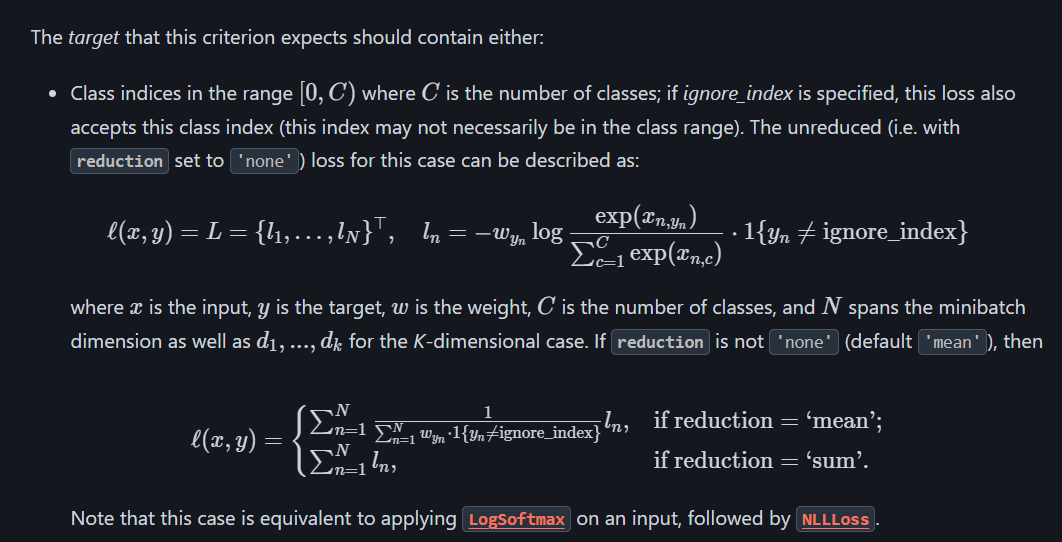

https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html


公式解读：
- 当reduction为none时，即类似大数据map-reduce的过程，首先对每一个样本\像素位置计算一个loss（map），把每一个元素的loss做聚合（reduce），得到一个loss值，这个loss值就是整个batch的loss值。reduction即控制reduce的方式，有none、mean、sum三种方式，none即不做reduce，直接返回每一个样本的loss值，mean即对批次内每一个样本的loss求均值，sum即对批次内每一个样本的loss求和。


当reduction为none时，loss的shape与input的shape相同，即每一个样本对应一个loss值。对应上面的公式。

#### 符号的含义：
- C是类别数class count，
- x是模型输出的logits，未归一化的分数，
    - xn,c：第n个样本（n位置的像素），第c个类别的logits值
- y是标签，这里表示类别索引的形式，即y的值是0~C-1的整数，表示第n个样本的标签label是哪一个即第y个类别，
- w是类别权重，长度为C，即每个分类的权重，默认是1，即每个样本的权重都一样，也可以设置每个样本的权重不一样，比如在训练时，有的样本更重要，有的样本不那么重要，可以设置权重，权重越大，loss对样本的影响越大，权重越小，loss对样本的影响越小。在某些时候，比如数据不均衡，有的类别样本多，有的类别样本少，可以设置类别权重，使得loss对类别样本多的类别的影响小，对类别样本少的类别的影响大，这样可以使模型在训练时更关注类别样本少的类别，从而提高模型对类别样本少的类别的分类能力。
    -Wyn ：第n个样本的权重
- N：要算损失的元素个数，
    - 分类：通常是batch size
    - 分割：通常是像素个数：batch size * height * width
- 1{⋅}：指示函数，即当条件为真时，值为1，当条件为假时，值为0。



#### Softmax
- exp 指的指数函数，即e的x次方
    - 分子 exp(xn,yn) ：第n个样本（n位置的像素），第yn个类别的logits值取指数，即第n个样本的标签label是哪一个即第yn个类别，把该类别的logits打分取指数，变成一个正数的权重
    - 分母 exp(xn,0) + exp(xn,1) + ... + exp(xn,C-1)，把所有类别的logits打分取指数，求和，得到一个正数的权重和，即所有类别的权重和为1，符合概率分布
    

#### 负对数似然函数
如果模型给出的真实类别的概率Pn,yn越大，那么log(Pn,yn)越接近0（log1=0）损失越小，反之，如果模型给出的真实类别的概率Pn,yn越小，log(Pn,yn)是个很大的负数，加上符号就变成了很大的正损失那么loss值就越大。
- 负号：因为我们是求最小化loss，所以用负号，变成最大化似然函数
- log：对数函数，因为指数函数的值可能非常大，对数函数可以把指数函数的值变小，方便计算
- Softmax：把logits值归一化，变成概率分布，即所有类别的概率和为1，符合概率分布

#### Wyn 类别权重，按照类别去放大或者缩小loss
- ln = -Wyn * log(Pn,yn)
    - 如果某一类很少，少数类，可以设置很大的w
    - 对于同样的预测错误，同样的-log（P），少数类会产生更大的损失，训练就会更加重视这部分的损失，从而提高模型对少数类的分类能力即让少数类的每个样本在优化目标里更有分量。
    

#### 1{yn ≠ ignore_index} ——把某些位置“完全不计入
- 若yn=ignore_index，指示函数为 0，则整个 ln=0。
- 等价于：这个样本/像素 既不贡献损失，也不产生梯度（被忽略）。
- 常见在语义分割里：把未标注区域、边界无效区域用 ignore_index 标起来，训练时跳过。


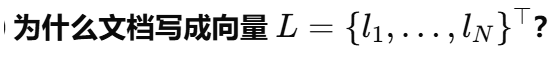

因为当 reduction='none' 时，loss 不会立刻变成一个标量，而是给你每个元素的损失：
    - 分类:返回形状 (N)
    - 分割:返回形状 (N,d1....dK)
之后如果你选择 reduction='mean' 或 'sum'，才会把这些 ln汇总成一个数

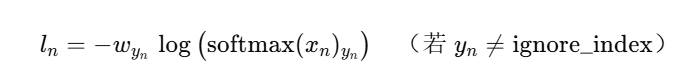

推荐使用类别标签的形式，即类似one-hot编码的形式，因为target是类索引时性能更好，只有当这种情况的限制太大时，才考虑使用提供target为类别的概率，
注意公式的不同，类别为概率时需要做加权求和，而类别为索引时，只需要对对应位置取值即可。
用到时再仔细研究吧
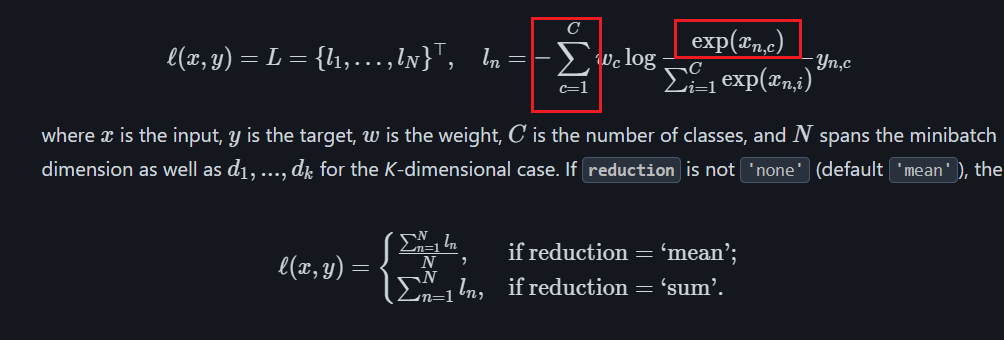


In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch

In [2]:
from torch import nn
loss = nn.CrossEntropyLoss()

In [4]:
input = torch.randn(3, 5, requires_grad=True)#模拟batch=3，类别=5的输入

In [5]:
input

tensor([[-0.0192, -0.3863, -1.2735, -0.7815, -2.3062],
        [-0.8697,  1.0036, -0.9340,  0.6924, -0.9373],
        [-0.7580, -1.7073,  0.6045, -0.8192, -0.8317]], requires_grad=True)

In [ ]:
target = torch.empty(3, dtype=torch.long).random_(5)#模拟batch=3的标签
#torch.empty是一种未初始化的tensor，random_(5)表示随机生成0-4的整数，dtypte=torch.long表示数据类型为long

In [ ]:
target#只取target的logits进行loss计算，其他的logits不参与计算

tensor([3, 0, 1])

In [8]:
loss(input, target)

tensor(2.4216, grad_fn=<NllLossBackward0>)

In [9]:
softmax = nn.Softmax(dim=1)

In [ ]:
softmax(input)#这里的input模拟的是nn的logits，即经过线性变换后的输出

tensor([[0.3927, 0.2721, 0.1120, 0.1833, 0.0399],
        [0.0707, 0.4600, 0.0663, 0.3370, 0.0660],
        [0.1396, 0.0540, 0.5453, 0.1313, 0.1297]], grad_fn=<SoftmaxBackward0>)

In [ ]:
torch.log(softmax(input))
#target =tensor([3, 0, 1])

tensor([[-0.9346, -1.3017, -2.1889, -1.6969, -3.2216],
        [-2.6498, -0.7765, -2.7140, -1.0877, -2.7174],
        [-1.9689, -2.9182, -0.6063, -2.0301, -2.0426]], grad_fn=<LogBackward0>)

In [13]:
-1.6969+(-2.6498)+(-2.9182)

-7.264900000000001

In [15]:
(-1.6969+(-2.6498)+(-2.9182))/3

-2.4216333333333337

In [16]:
loss(input, target)

tensor(2.4216, grad_fn=<NllLossBackward0>)

In [18]:
nn.LogSoftmax(dim=1)(input)

tensor([[-0.9346, -1.3017, -2.1889, -1.6969, -3.2216],
        [-2.6498, -0.7765, -2.7140, -1.0877, -2.7174],
        [-1.9689, -2.9182, -0.6063, -2.0301, -2.0426]],
       grad_fn=<LogSoftmaxBackward0>)

In [17]:
nn.NLLLoss()(nn.LogSoftmax(dim=1)(input), target)

tensor(2.4216, grad_fn=<NllLossBackward0>)

In [19]:
nn.NLLLoss()(torch.log(nn.Softmax(dim=1)(input)), target)


tensor(2.4216, grad_fn=<NllLossBackward0>)